<a href="https://colab.research.google.com/github/AndrzejOlejniczak/Neural-Networks/blob/main/04_2_transfer_learning_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning with TensorFlow
## Part 2: Fine tuning

In [1]:
# Are we using the GPU
!nvidia-smi

Sun Aug 21 14:01:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Creating and importing helper functions

In [2]:
# My own plot the curves function
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def plot_curves_with_regression(history, order=2):
    
    '''
    Uses seaborn and to plot curves 
    as scatterplot with regression
    attrs:
    history: history object
    order: order of regression curve 
    default order=2   
    '''
    
    # Create DataFrame
    df = pd.DataFrame(history.history)
    
    # Setup the figure
    plt.figure(figsize=(32, 8))
    plt.suptitle(f'Model {history.model.name} metrics', fontsize='x-large')
    
    # Plot loss
    plt.subplot(1, 2, 1)
    sns.regplot(x='index', y='loss', data=df.reset_index(), 
                order=order, label='Training Loss')
    sns.regplot(x='index', y='val_loss', data=df.reset_index(), 
                order=order, label='Validation Loss')
    plt.legend()
    plt.title('Loss Curves')

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    sns.regplot(x='index', y='accuracy', data=df.reset_index(), 
                order=order, label='Training Accuracy')
    sns.regplot(x='index', y='val_accuracy', data=df.reset_index(), 
                order=order, label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy Curves')

In [3]:
# Importing DBourke helper functions: 'https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py'
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-08-21 14:01:03--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-21 14:01:03 (118 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [44]:
# Import helper function
from helper_functions import unzip_data, walk_through_dir
import datetime

In [45]:
def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.

  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir,
      update_freq='epoch'
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

### Get the data

In [5]:
# Get 10% of ten classes food101 dataset
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2022-08-21 14:01:05--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.212.128, 173.194.213.128, 173.194.214.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   208MB/s    in 0.8s    

2022-08-21 14:01:06 (208 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [6]:
# Unzip the data using a function
unzip_data('10_food_classes_10_percent.zip')

In [7]:
# Walk through directory
walk_through_dir('10_food_classes_10_percent')

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

In [8]:
# Create training and test dirs
train_dir = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

In [9]:
# Create datasets
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_10_percent = image_dataset_from_directory(directory=train_dir, 
                                                image_size=(224, 224), 
                                                label_mode='categorical',
                                                batch_size=32)

test_10_percent = image_dataset_from_directory(directory=test_dir,
                                               image_size=(224, 224),
                                               label_mode='categorical',
                                               batch_size=32)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [10]:
train_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [11]:
# See an example of a batch of the train dataset
import matplotlib.pyplot as plt
for images, labels in train_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[7.46428604e+01 4.26428566e+01 1.76428566e+01]
   [7.39030609e+01 4.19030609e+01 1.89030609e+01]
   [7.35714264e+01 4.15714302e+01 1.90000000e+01]
   ...
   [4.53112297e+01 3.19540215e+01 2.31122923e+00]
   [4.96633987e+01 3.36633987e+01 8.80628300e+00]
   [6.35814018e+01 4.55814018e+01 2.55814037e+01]]

  [[7.07602081e+01 3.87602043e+01 1.57602043e+01]
   [7.37908173e+01 4.17908134e+01 1.87908173e+01]
   [7.41275558e+01 4.21275520e+01 1.95561218e+01]
   ...
   [4.48416405e+01 3.38416405e+01 5.44372320e+00]
   [4.22041435e+01 2.62704716e+01 1.54600525e+00]
   [5.50510597e+01 3.80510597e+01 1.80510597e+01]]

  [[7.32091827e+01 4.12091866e+01 1.82091827e+01]
   [7.46428604e+01 4.26428566e+01 1.96428585e+01]
   [7.14285736e+01 3.94285698e+01 1.68571434e+01]
   ...
   [4.19182968e+01 3.17040100e+01 4.48972416e+00]
   [4.17296219e+01 2.89030571e+01 5.17347527e+00]
   [4.81531105e+01 3.27245407e+01 1.19388247e+01]]

  ...

  [[6.85717773e+00 5.85717773e+00 3.85717773e+00]
   [8

### Model 0: Create a baseline model using keras functional API

In [12]:
import tensorflow as tf
tf.__version__

'2.8.2'

In [46]:
# 1. Create the baseline model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the baseline model
base_model.trainable = False

# 3. Create inputs into the baseline model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='input_layer')

# 4. Normalize the inputs (obligatory depending on the model eg. ResNet50V2 -EfficientNet does not need this)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)

print(f'Shape after passing inputs through base model: {x.shape}')

# 6. Average-pool the putputs of the base model (aggregate all the most important information, reduce number of comupations)
x  = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
print(f'Shape after GlobalAveragePooling2D: {x.shape}')

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)


In [47]:
model_0.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [48]:
# 9. Compile the model
model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [49]:
# 10. Fit the model
hisotry_0 = model_0.fit(train_10_percent,
                        validation_data=test_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_10_percent),
                        validation_steps=len(test_10_percent),
                        callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                               experiment_name='model_0_10_percent')])

Saving TensorBoard log files to: transfer_learning/model_0_10_percent/20220821-141951
Epoch 1/5
24/24 [==============================] - 14s 348ms/step - loss: 1.8814 - accuracy: 0.4347 - val_loss: 1.3434 - val_accuracy: 0.6948
Epoch 2/5
24/24 [==============================] - 7s 288ms/step - loss: 1.1504 - accuracy: 0.7347 - val_loss: 0.9285 - val_accuracy: 0.7860
Epoch 3/5
24/24 [==============================] - 7s 289ms/step - loss: 0.8455 - accuracy: 0.8067 - val_loss: 0.7542 - val_accuracy: 0.8220
Epoch 4/5
24/24 [==============================] - 7s 291ms/step - loss: 0.6897 - accuracy: 0.8360 - val_loss: 0.6628 - val_accuracy: 0.8308
Epoch 5/5
24/24 [==============================] - 7s 292ms/step - loss: 0.5923 - accuracy: 0.8640 - val_loss: 0.6086 - val_accuracy: 0.8368


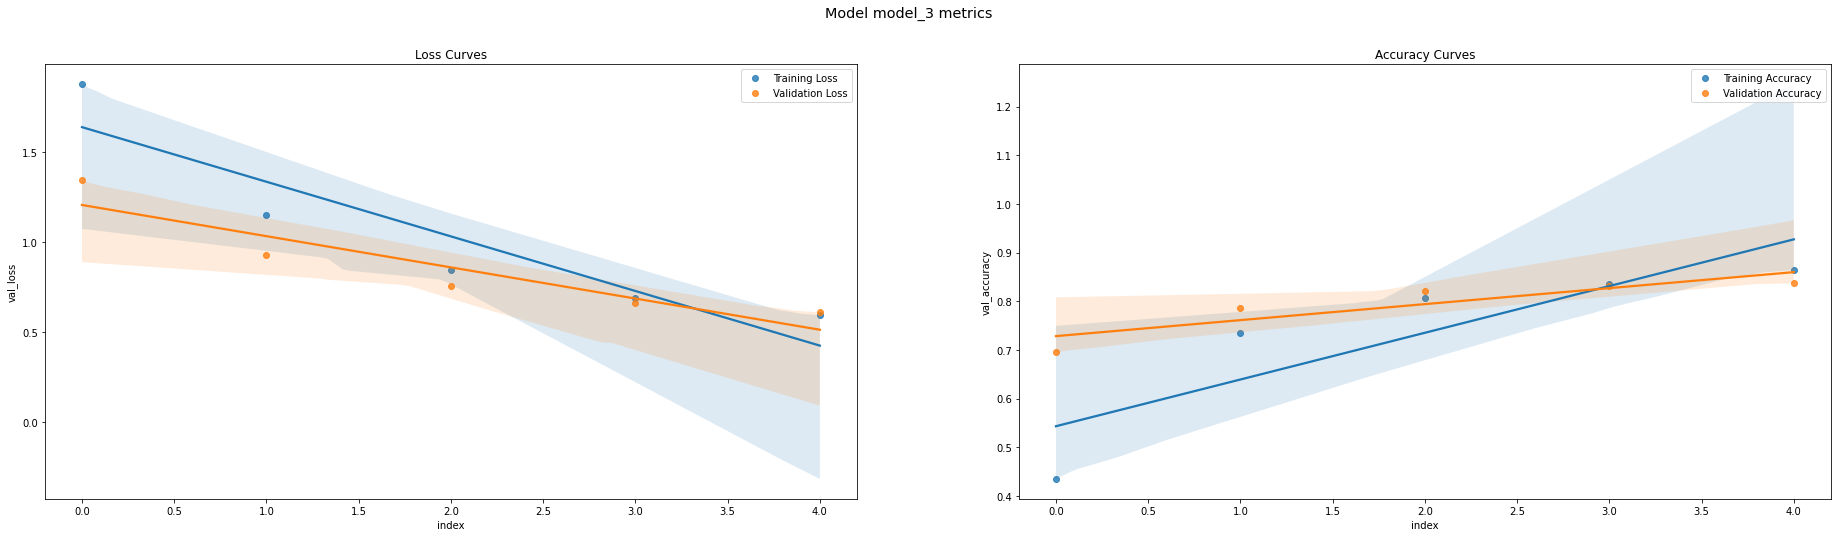

In [52]:
plot_curves_with_regression(hisotry_0, order=1)

In [53]:
# Evaluate the model on the test data
model_0.evaluate(test_10_percent)

79/79 [==============================] - 6s 67ms/step - loss: 0.6086 - accuracy: 0.8368


[0.6086084246635437, 0.8367999792098999]

In [54]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_6
1 rescaling_3
2 normalization_3
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_d

In [55]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_3 (Rescaling)        (None, None, None,   0           ['input_6[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_3 (Normalization  (None, None, None,   7          ['rescaling_3[0][0]']            
 )                              3)                                                   

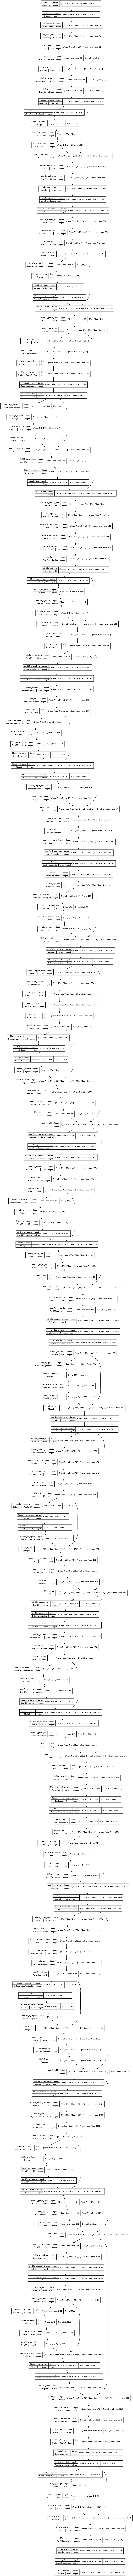

In [56]:
# Import plot_model func
from tensorflow.keras.utils import plot_model

# Plot the base model 
plot_model(base_model, show_shapes=True, show_layer_activations=True) 


In [57]:
model_0.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


### Getting a feature vector from a trained model
Let's pass a random tensor through GlobalAveragePooling2D.

In [ ]:
# Define the input shape
in_shp = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(in_shp)

input_tensor

<tf.Tensor: shape=(1, 4, 4, 3), dtype=float32, numpy=
array([[[[ 0.3274685 , -0.8426258 ,  0.3194337 ],
         [-1.4075519 , -2.3880599 , -1.0392479 ],
         [-0.5573232 ,  0.539707  ,  1.6994323 ],
         [ 0.28893656, -1.5066116 , -0.2645474 ]],

        [[-0.59722406, -1.9171132 , -0.62044144],
         [ 0.8504023 , -0.40604794, -3.0258412 ],
         [ 0.9058464 ,  0.29855987, -0.22561555],
         [-0.7616443 , -1.8917141 , -0.93847126]],

        [[ 0.77852213, -0.47338897,  0.97772694],
         [ 0.24694404,  0.20573747, -0.5256233 ],
         [ 0.32410017,  0.02545409, -0.10638497],
         [-0.6369475 ,  1.1603122 ,  0.2507359 ]],

        [[-0.41728503,  0.4012578 , -1.4145443 ],
         [-0.5931857 , -1.6617213 ,  0.33567193],
         [ 0.10815629,  0.23479682, -0.56668764],
         [-0.35819843,  0.88698614,  0.52744764]]]], dtype=float32)>

In [ ]:
global_avg_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)

In [ ]:
global_avg_pooled_tensor

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [ ]:
import numpy as np
for n in range(0,3):
  print(np.mean(input_tensor[:,:,:,n]))

-0.093686484
-0.45840448
-0.28855976


In [ ]:
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [ ]:
# Get the tensor from input_tensor
global_max_pooled_tensor = tf.keras.layers.GlobalMaxPooling2D()(input_tensor)

In [ ]:
global_max_pooled_tensor

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>

In [ ]:
tf.reduce_max(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>

**Here the tutor does not show how to get a feature vector from trained models layer. 
I do it myself.**

In [ ]:
model_0.layers[0].output


<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_layer')>

In [ ]:
tf.random.set_seed(42)
input_tensor_2 = tf.random.normal(shape=(1, 224, 224, 3))

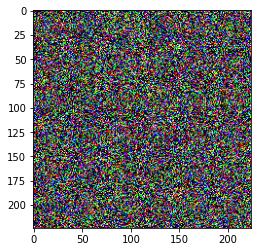

In [ ]:
plt.imshow(tf.squeeze(input_tensor_2))

In [ ]:
real_feature_vector = model_0.layers[2](model_0.layers[1](input_tensor_2))
real_feature_vector

<tf.Tensor: shape=(1, 1280), dtype=float32, numpy=
array([[-0.04030248, -0.03299154, -0.07522038, ..., -0.07529924,
         0.02205181, -0.09755751]], dtype=float32)>

In [ ]:
model_0.layers[3](real_feature_vector)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.13772629, 0.10371401, 0.11376759, 0.07881379, 0.08060256,
        0.06597164, 0.13401118, 0.131716  , 0.08990432, 0.06377267]],
      dtype=float32)>

In [ ]:
index = tf.math.argmax(model_0.layers[3](real_feature_vector), axis=1).numpy().item()
index

0

In [ ]:
train_10_percent.class_names[index]

'chicken_curry'

I am not surprised that a normally distributed picture is recognized as chicken curry.
Let's check how does the featire vector look like if plotted.

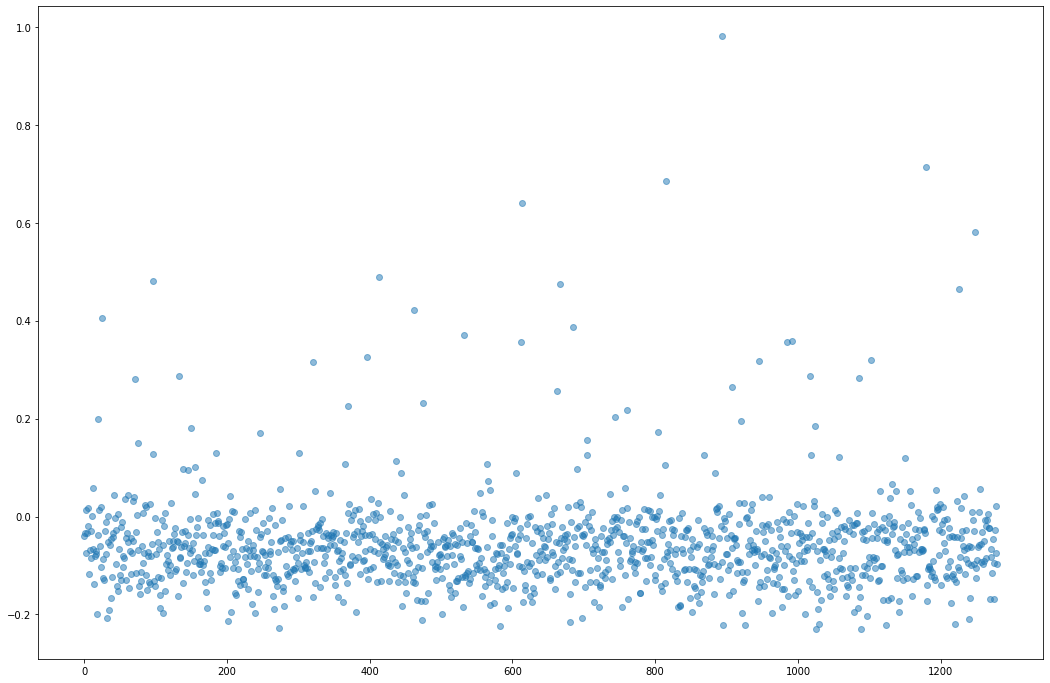

In [ ]:
plt.figure(figsize=(18, 12))
plt.scatter(range(len(real_feature_vector[0])), real_feature_vector[0], alpha=0.5)

Let's retrieve a series of feature vectors: few per class and see, how their feature vectors look like

In [ ]:
dataset_tuple = next(train_10_percent.as_numpy_iterator())

In [ ]:
dataset_tuple[0]

array([[[[1.36397964e+02, 1.77397964e+02, 2.33397964e+02],
         [1.37428558e+02, 1.78428558e+02, 2.32428558e+02],
         [1.40270401e+02, 1.79698975e+02, 2.34484695e+02],
         ...,
         [7.01581573e+01, 8.31530457e+01, 1.21091789e+02],
         [6.64438248e+01, 7.62499008e+01, 1.10612129e+02],
         [7.26071167e+01, 8.05356903e+01, 1.13433655e+02]],

        [[1.27658157e+02, 1.68658157e+02, 2.24658157e+02],
         [1.29510208e+02, 1.70510208e+02, 2.24510208e+02],
         [1.31045914e+02, 1.70474487e+02, 2.25260208e+02],
         ...,
         [6.98979797e+01, 8.76683884e+01, 1.27198990e+02],
         [7.26071548e+01, 8.77346573e+01, 1.26535690e+02],
         [7.20969391e+01, 8.78826523e+01, 1.23765305e+02]],

        [[1.29479599e+02, 1.70479599e+02, 2.24479599e+02],
         [1.29933670e+02, 1.70505096e+02, 2.24719391e+02],
         [1.30040817e+02, 1.69377548e+02, 2.24209183e+02],
         ...,
         [6.80969315e+01, 8.32653198e+01, 1.20979599e+02],
         [

In [ ]:
dataset_tuple[0].shape

(32, 224, 224, 3)

In [ ]:
list_of_labels = []
for n in range(32):
  list_of_labels.append(np.argmax(dataset_tuple[1][n, :]))
list_of_labels

[2,
 7,
 3,
 1,
 5,
 4,
 3,
 6,
 2,
 3,
 6,
 4,
 0,
 8,
 5,
 5,
 8,
 2,
 2,
 4,
 4,
 5,
 1,
 2,
 2,
 2,
 3,
 3,
 9,
 6,
 6,
 3]

In [ ]:
list_of_pictures = []
for n in range(32):
  list_of_pictures.append(dataset_tuple[0][n, :, :, :])

In [ ]:
list_of_pictures[0].shape

(224, 224, 3)

In [ ]:
# Defining a plotting function
def showimg_showvector(image_tensor, label, model, functional_layer_number=1, pooling_layer_number=2, class_name_list=train_10_percent.class_names):
  
  # Retrieve a feature vector
  real_feature_vector = model.layers[pooling_layer_number](model.layers[functional_layer_number](image_tensor))

  # Plot the feature vector with a class name
  plt.figure(figsize=(12, 8))
  plt.scatter(range(len(real_feature_vector[0])), real_feature_vector[0], alpha=0.5)
  plt.title(f'{class_name_list[label]}')

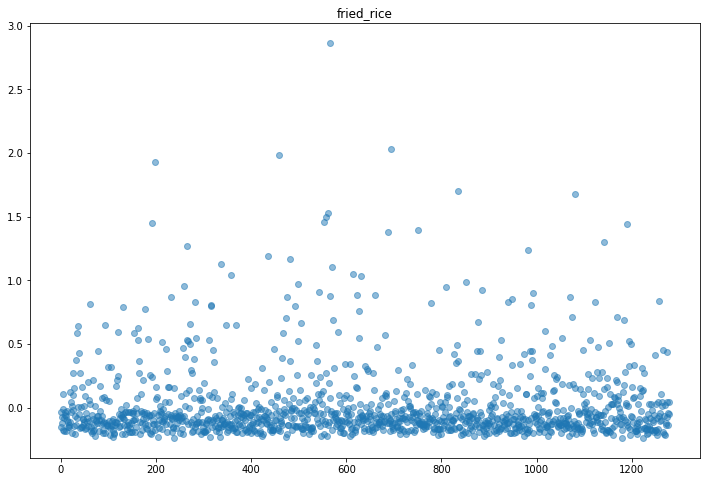

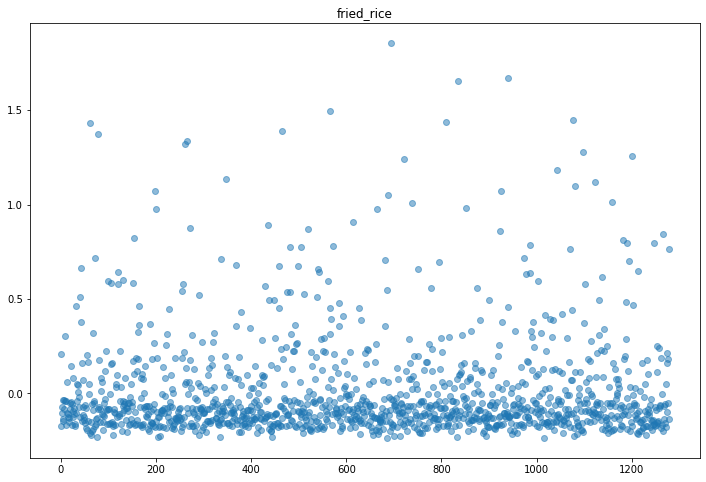

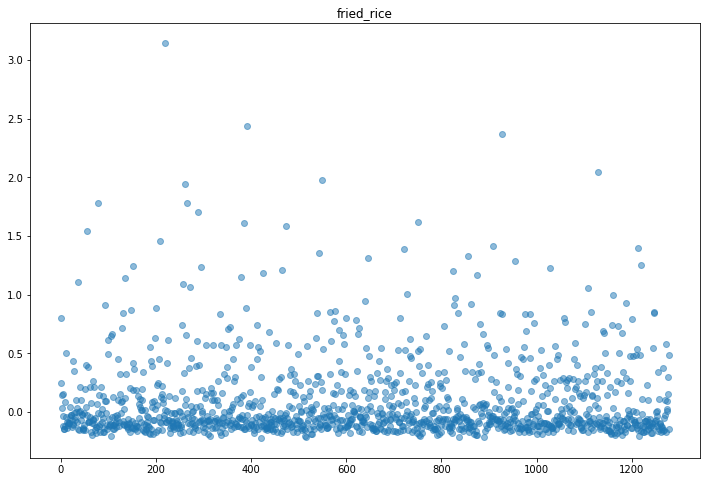

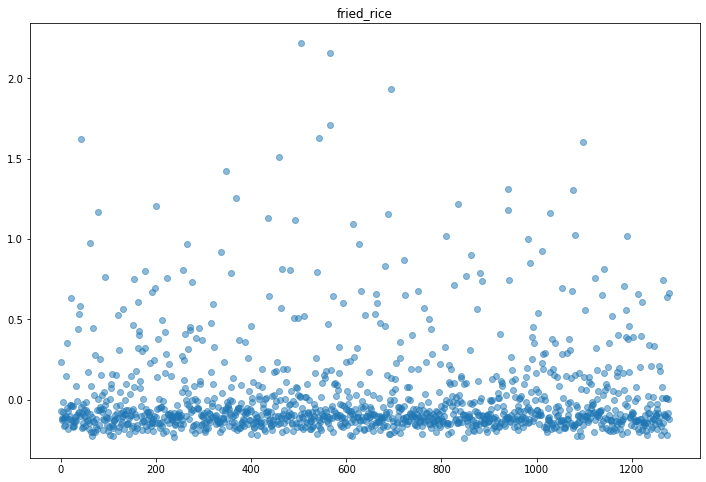

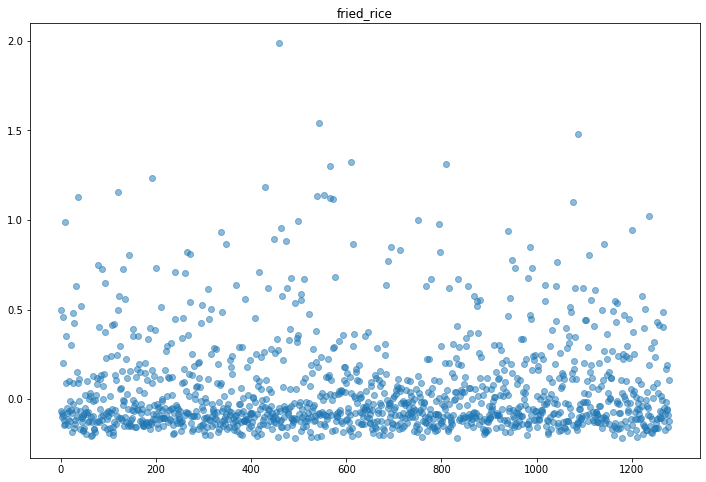

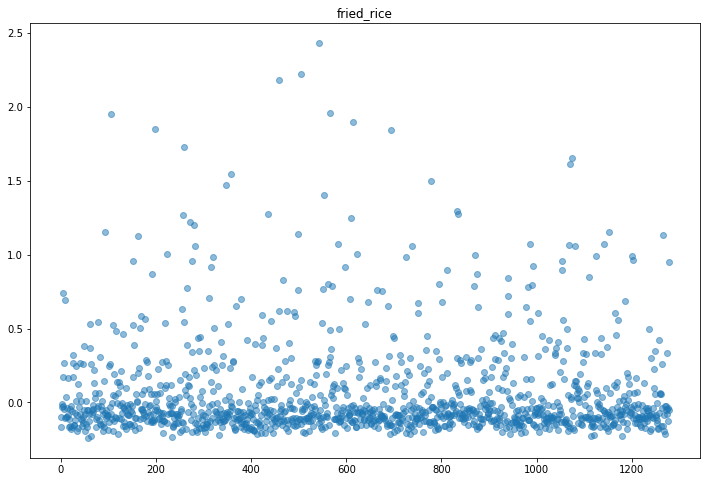

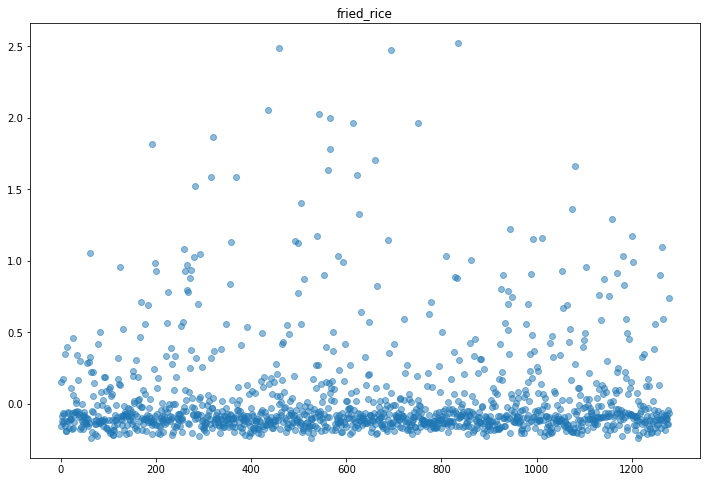

In [ ]:
for m in range(32):
  if list_of_labels[m] == 2:
    showimg_showvector(list_of_pictures[m], list_of_labels[m], model=model_0)

In [ ]:
normal_sample_df = pd.DataFrame(real_feature_vector[0], range(len(real_feature_vector[0])), columns=['zero'])

normal_sample_df

zero
0    -0.040302
1    -0.032992
2    -0.075220
3     0.012641
4    -0.033657
...        ...
1275 -0.169390
1276 -0.027407
1277 -0.075299
1278  0.022052
1279 -0.097558

[1280 rows x 1 columns]

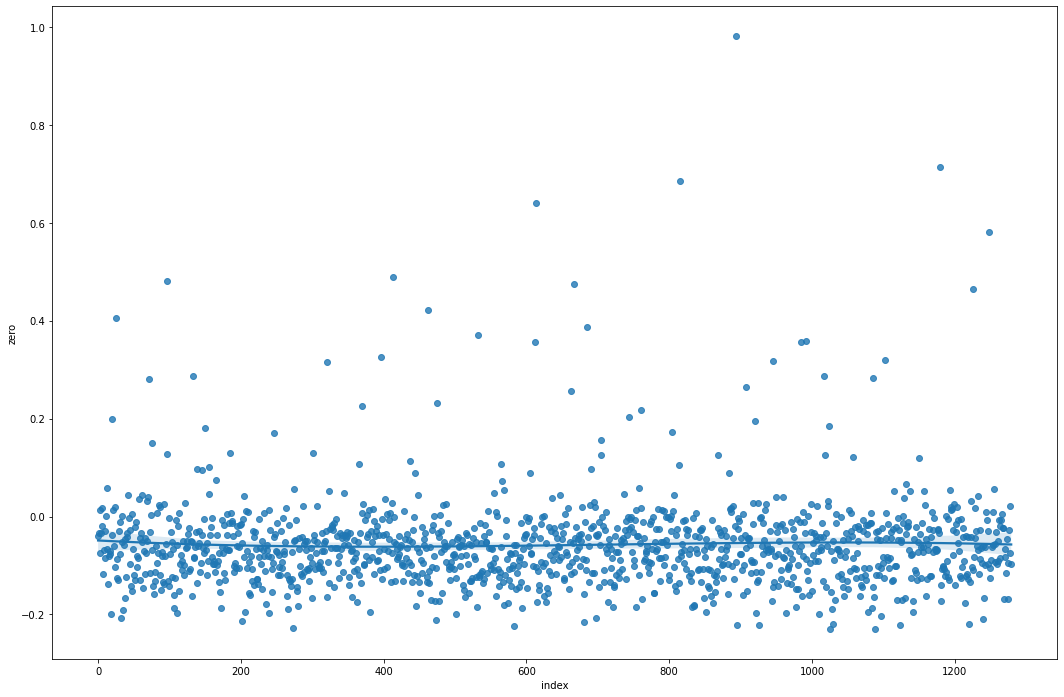

In [ ]:
plt.figure(figsize=(18, 12))
sns.regplot(x='index', y='zero', data=normal_sample_df.reset_index(), order=3)

In [ ]:
normal_sample_df_truncated = normal_sample_df.copy()

In [ ]:
normal_sample_df_truncated[normal_sample_df_truncated < 0.1] = 0
normal_sample_df_truncated['index_column'] = normal_sample_df_truncated.index


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3718: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

In [ ]:
normal_sample_df_truncated_50 = normal_sample_df.copy()
normal_sample_df_truncated_50['index_column'] = normal_sample_df_truncated_50.index
normal_sample_df_truncated_50 = normal_sample_df_truncated_50.nlargest(50, 'zero')

In [ ]:
normal_sample_df_truncated = normal_sample_df_truncated[normal_sample_df_truncated['zero'] != 0]

In [ ]:
normal_sample_df_truncated_50.shape

(50, 2)

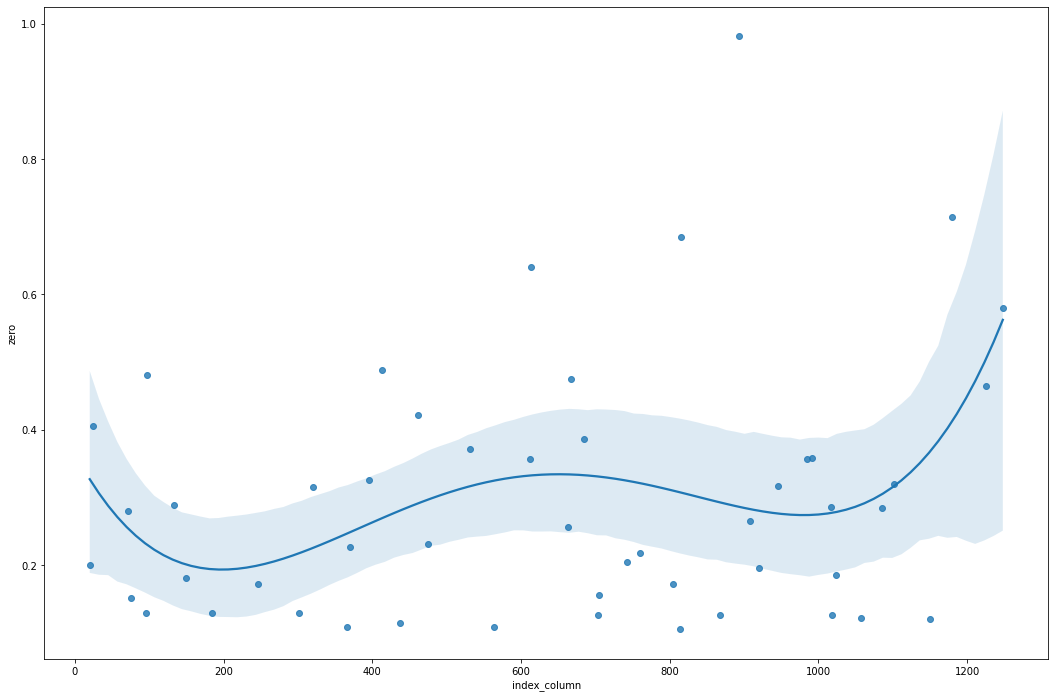

In [ ]:
plt.figure(figsize=(18, 12))
sns.regplot(x='index_column', y='zero', data=normal_sample_df_truncated_50, order=4)

I want to check if feature vectors are overloaded with information.

One can 


### Series of transfer learning experiments

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation

2. `model_2` - use feature extraction transfer learning with 10% of the training data with data augmentation

3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation

4. `model_4` - use fine-tuning transfer learning on 100% of the trainig data with data augmentation.


**Across all experiments the same test dataset will be used to ensure consistency of evaluations.**

#### Download and prepare the data

In [58]:
# Get the files
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

# Unzip data
unzip_data('10_food_classes_1_percent.zip')

--2022-08-21 14:26:47--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.193.128, 172.217.204.128, 172.217.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.1’

10_food_classes_1_p 100%[===================>] 127.42M   316MB/s    in 0.4s    

2022-08-21 14:26:47 (316 MB/s) - ‘10_food_classes_1_percent.zip.1’ saved [133612354/133612354]



In [59]:
# Create training and test dirs
train_dir_1_percent = '10_food_classes_1_percent/train'
test_dir_1_percent = '10_food_classes_1_percent/test'

In [60]:
# Walk through the data
walk_through_dir('10_food_classes_1_percent')

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'

In [61]:
# Create the datasets
train_1_percent = image_dataset_from_directory(train_dir_1_percent,
                                               label_mode='categorical',
                                               image_size=(224, 224),
                                               batch_size=32)

test_1_percent = image_dataset_from_directory(test_dir_1_percent,
                                               label_mode='categorical',
                                               image_size=(224, 224),
                                               batch_size=32)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


#### Add data augmentation
To add data augmentation right into the model, use the layers inside

`tf.keras.layers.preprocessing`

In [62]:
# import experimental layers for preprocessing
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing

In [63]:
# Create data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = tf.keras.Sequential([
    tf.keras.Input(shape=(224, 224, 3)),
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    tf.keras.layers.RandomCrop(224, 224, seed=44)], name='data_augmentation')

#### Visualize data augmentation

In [64]:
# Create data augmentation layer with no Input
data_augmentation_freeinput = tf.keras.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    tf.keras.layers.RandomCrop(224, 224, seed=44)], name='data_aug_freeinput')


In [65]:
# View a random image and comapre it to augmented version
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_1_percent.class_names)
target_dir = '10_food_classes_1_percent/train/' + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + '/' + random_image

print(random_image_path)

10_food_classes_1_percent/train/fried_rice/1677058.jpg


(-0.5, 223.5, 223.5, -0.5)

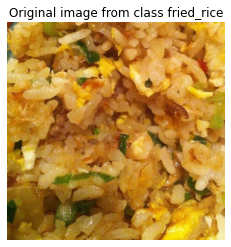

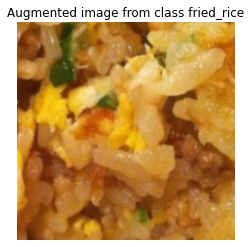

In [66]:
# Read random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f'Original image from class {target_class}')
plt.axis(False)

# Read augmented image
augmented_image = data_augmentation_freeinput(img, training=True)
plt.figure()
plt.imshow(augmented_image/255.)
plt.title(f'Augmented image from class {target_class}')
plt.axis(False)

#### Create model_1
Feature extraction transfer learning on 1% of the data with data augmentation.

In [67]:
# Setup base model and freeze base model layers
input_shape = (224, 224, 3)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = tf.keras.Input(shape=input_shape, name='input_layer')

# Add data augmentation 
x = data_augmentation(inputs)

# Add base model
x = base_model(x, training=False)

# Pool output features of the base model
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Create a dense layer for classification and join it
output = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# Create a model
model_1 = tf.keras.Model(inputs, output)

# Compile the model
model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])


In [68]:
model_1.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [69]:
history_1 = model_1.fit(train_1_percent,
                        epochs=5,
                        steps_per_epoch=len(train_1_percent),
                        validation_data=test_1_percent,
                        validation_steps=int(0.25*len(test_1_percent)),
                        callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                               experiment_name='1_percent_data_aug')])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20220821-142809
Epoch 1/5
3/3 [==============================] - 9s 2s/step - loss: 2.3243 - accuracy: 0.1000 - val_loss: 2.2478 - val_accuracy: 0.1497
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.0722 - accuracy: 0.2714 - val_loss: 2.1185 - val_accuracy: 0.2253
Epoch 3/5
3/3 [==============================] - 2s 780ms/step - loss: 1.8834 - accuracy: 0.4571 - val_loss: 2.0187 - val_accuracy: 0.2928
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.7431 - accuracy: 0.5143 - val_loss: 1.9176 - val_accuracy: 0.3668
Epoch 5/5
3/3 [==============================] - 2s 779ms/step - loss: 1.6231 - accuracy: 0.6429 - val_loss: 1.8284 - val_accuracy: 0.4095


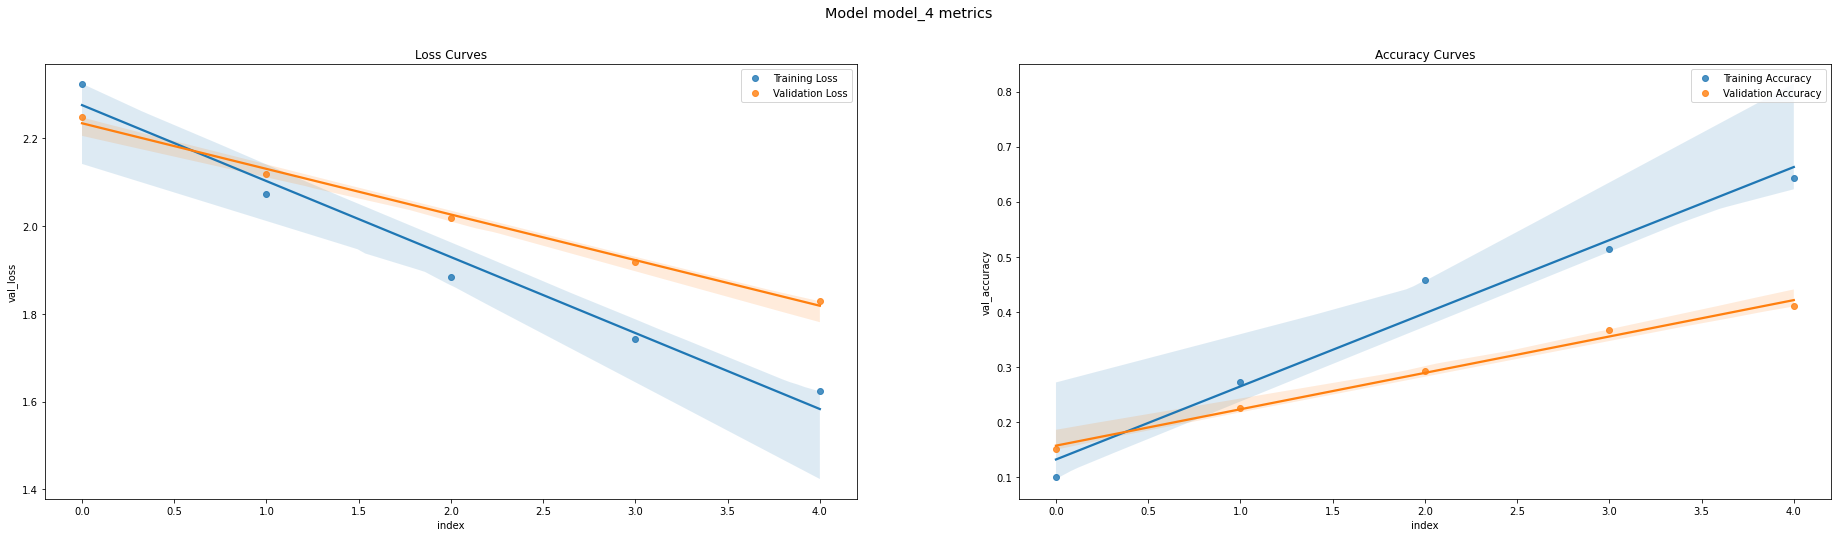

In [70]:
# Plot model_1 performance
plot_curves_with_regression(history_1, order=1)

#### Create model_2 
Fature extraction transfer learning on 10% of the data with data augmentation.

In [71]:
# Create a model
model_2 = tf.keras.Model(inputs, output)

# Compile the model
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [72]:
model_2.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

##### Create a ModelCheckpoint callback
The ModelCheckpoint callback intermediatelly saves our model (full model or just weights) during training. This is useful so we can come and start where we left off.

In [73]:
# Import the class ModelCheckpoint callback
from tensorflow.keras.callbacks import ModelCheckpoint

# Set checkpoint path
checkpoint_path = '10_percent_checkpoint_weights/checkpoint.ckpt'

# Create a ModelCheckpoint callback that save the model's weights only
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                      save_weights_only=True,
                                      save_best_only=False,
                                      save_freq='epoch',
                                      verbose=1)



In [74]:
# Fit the model

history_2 = model_2.fit(train_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_10_percent),
                        validation_data=test_1_percent,
                        validation_steps=int(0.25*len(test_1_percent)),
                        callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                               experiment_name='10_percent_data_aug'),
                                   checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20220821-142842
Epoch 1/5
23/24 [===========================>..] - ETA: 0s - loss: 1.6428 - accuracy: 0.5272
Epoch 1: saving model to 10_percent_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 11s 208ms/step - loss: 1.6353 - accuracy: 0.5307 - val_loss: 1.2100 - val_accuracy: 0.7188
Epoch 2/5
23/24 [===========================>..] - ETA: 0s - loss: 1.2127 - accuracy: 0.6929
Epoch 2: saving model to 10_percent_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 4s 145ms/step - loss: 1.2144 - accuracy: 0.6893 - val_loss: 0.9439 - val_accuracy: 0.7632
Epoch 3/5
23/24 [===========================>..] - ETA: 0s - loss: 0.9820 - accuracy: 0.7459
Epoch 3: saving model to 10_percent_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 5s 191ms/step - loss: 0.9908 - accuracy: 0.7400 - val_loss: 0.7985 - val_accuracy: 0.7895
Epoch 4/5
23/24 [==========

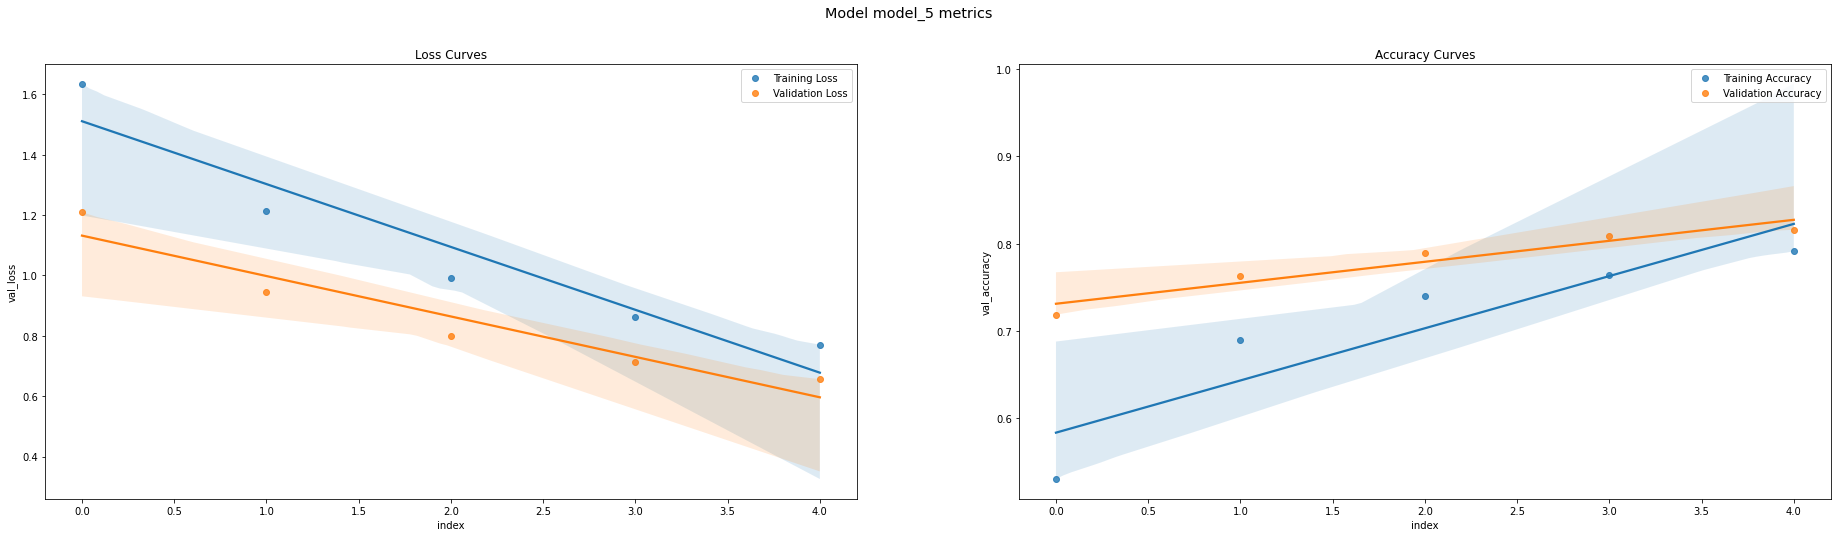

In [75]:
# Plot model_2's performance
plot_curves_with_regression(history_2, order=1)

In [76]:
model_2_eval_1 = model_2.evaluate(test_10_percent)

79/79 [==============================] - 6s 68ms/step - loss: 0.6606 - accuracy: 0.8192


In [77]:
model_2_eval_1

[0.6606315970420837, 0.8191999793052673]

##### Load model weights from the checkpoint file

In [78]:
model_2.load_weights(checkpoint_path)

In [79]:
model_2_eval_2 = model_2.evaluate(test_10_percent)

79/79 [==============================] - 6s 68ms/step - loss: 0.6606 - accuracy: 0.8192


In [80]:
model_2_eval_1 == model_2_eval_2

False

In [81]:
import numpy as np
np.isclose(np.array(model_2_eval_1), np.array(model_2_eval_2))

array([ True,  True])

In [82]:
np.array(model_2_eval_1) -  np.array(model_2_eval_2)

array([-1.1920929e-07,  0.0000000e+00])

#### Create model_3
Fine-tuning on last three layers of the base_model.

In [83]:
# Inspect model_2 layers
for layer in model_2.layers:
  print(layer.name, f'\n Is trainable: {layer.trainable}\n')

input_layer 
 Is trainable: True

data_augmentation 
 Is trainable: True

efficientnetb0 
 Is trainable: False

global_average_pooling2d_1 
 Is trainable: True

output_layer 
 Is trainable: True



In [84]:
# Inspect base_model layers
for idx, layer in enumerate(model_2.layers[2].layers):
  print(idx, layer.name, layer.trainable )

0 input_8 False
1 rescaling_4 False
2 normalization_4 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [85]:
# How many trainable layers are in the base model?
print(len(model_2.layers[2].trainable_variables))
print(len(model_2.trainable_variables))

0
2


In [86]:
# Make last 10 layers of the base_model trainable
base_model.trainable = True

for layer in base_model.layers[:-10]:
  layer.trainable = False

In [87]:
model_2.layers[2].trainable

True

In [88]:
# Recompile model_2 with new trainable layers and learning rate reduced by 10**-1
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=['accuracy'])

In [89]:
#@title Domyślny tekst tytułu
for idx, layer in enumerate(model_2.layers[2].layers):
  print(idx, layer.name, layer.trainable )

0 input_8 False
1 rescaling_4 False
2 normalization_4 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [90]:
# How many trainable layers are in the base model?
print(len(model_2.layers[2].trainable_variables))
print(len(model_2.trainable_variables))

10
12


In [91]:
# Check model_2's trainable variables
model_2.trainable_variables

[<tf.Variable 'block7a_se_reduce/kernel:0' shape=(1, 1, 1152, 48) dtype=float32, numpy=
 array([[[[-0.05485657,  0.07178846,  0.01534605, ..., -0.09284662,
            0.0104828 , -0.02693838],
          [-0.03157939,  0.02819107, -0.05579546, ...,  0.00487578,
            0.12001809, -0.06901816],
          [-0.07792544,  0.12601745,  0.03935236, ...,  0.03086486,
           -0.01581392,  0.1306234 ],
          ...,
          [-0.07692936,  0.19920062,  0.17471024, ...,  0.03312391,
           -0.04528928, -0.09214652],
          [ 0.01010198,  0.06855008,  0.05820991, ...,  0.00131649,
           -0.08952942, -0.00476829],
          [ 0.03583075, -0.01228165,  0.04561347, ..., -0.00822134,
           -0.07354517, -0.06507882]]]], dtype=float32)>,
 <tf.Variable 'block7a_se_reduce/bias:0' shape=(48,) dtype=float32, numpy=
 array([-0.10886215, -0.13624744, -0.15257476,  0.14799541, -0.08512902,
        -0.12059905, -0.08779966, -0.08187538, -0.06925284, -0.12518929,
        -0.0819265 ,

In [92]:
# Fine-tune model_2 for another 5 epochs
history_2_1 = model_2.fit(train_10_percent,
                          epochs=10,
                          validation_data=test_10_percent,
                          validation_steps=int(0.25*len(test_10_percent)),
                          initial_epoch=history_2.epoch[-1],
                          callbacks=[
                              create_tensorboard_callback(dir_name='transfer_learning',
                                                          experiment_name='10_percent_fine_last_10')
                          ])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_last_10/20220821-143000
Epoch 5/10
24/24 [==============================] - 12s 224ms/step - loss: 0.6782 - accuracy: 0.8160 - val_loss: 0.4745 - val_accuracy: 0.8618
Epoch 6/10
24/24 [==============================] - 5s 185ms/step - loss: 0.5616 - accuracy: 0.8347 - val_loss: 0.4347 - val_accuracy: 0.8651
Epoch 7/10
24/24 [==============================] - 5s 184ms/step - loss: 0.5083 - accuracy: 0.8440 - val_loss: 0.4554 - val_accuracy: 0.8536
Epoch 8/10
24/24 [==============================] - 5s 185ms/step - loss: 0.4697 - accuracy: 0.8467 - val_loss: 0.3979 - val_accuracy: 0.8668
Epoch 9/10
24/24 [==============================] - 5s 185ms/step - loss: 0.4191 - accuracy: 0.8733 - val_loss: 0.3963 - val_accuracy: 0.8799
Epoch 10/10
24/24 [==============================] - 5s 184ms/step - loss: 0.3750 - accuracy: 0.8973 - val_loss: 0.3563 - val_accuracy: 0.8734


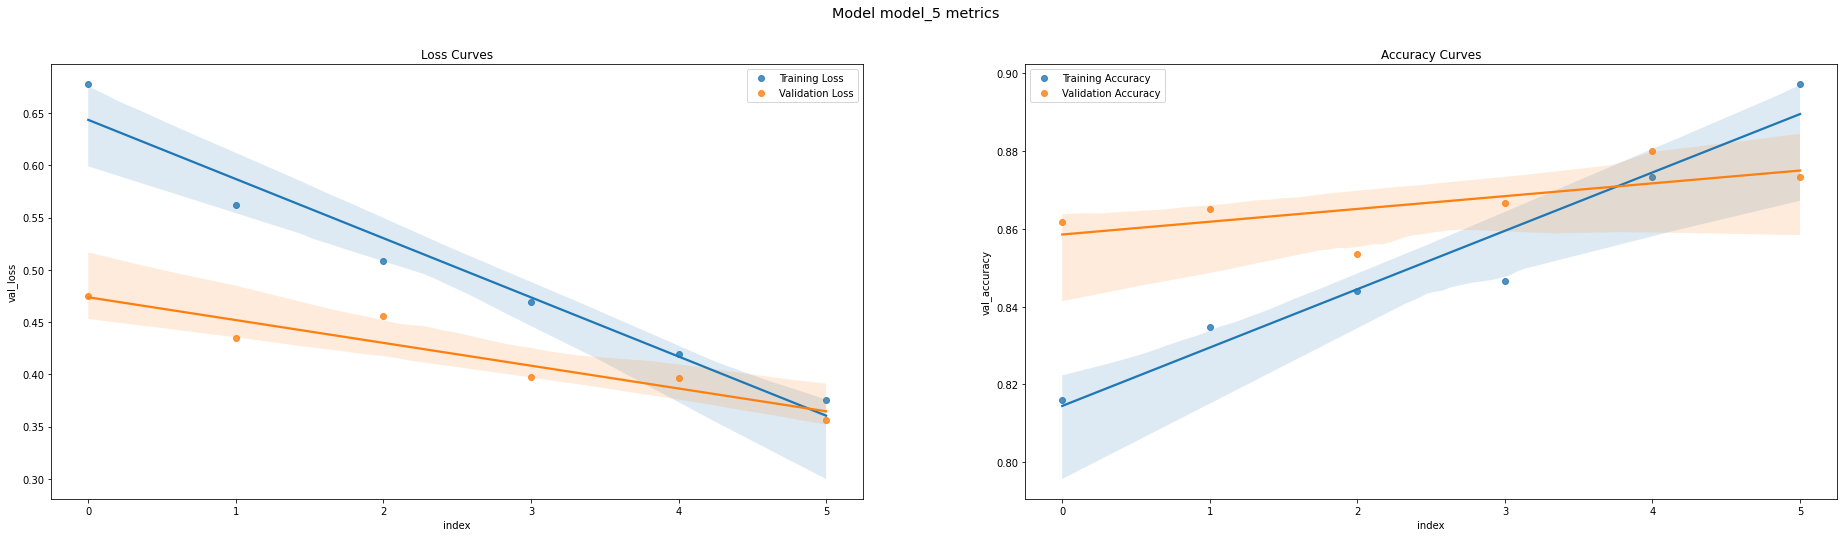

In [93]:
plot_curves_with_regression(history_2_1, order=1)

In [94]:
model_2.evaluate(test_10_percent)

79/79 [==============================] - 6s 68ms/step - loss: 0.4801 - accuracy: 0.8348


[0.48007118701934814, 0.8348000049591064]

In [95]:
history_2_1.history

{'loss': [0.6781795024871826,
  0.5616446733474731,
  0.5082806348800659,
  0.4696747958660126,
  0.41914892196655273,
  0.37503495812416077],
 'accuracy': [0.8159999847412109,
  0.8346666693687439,
  0.843999981880188,
  0.846666693687439,
  0.8733333349227905,
  0.8973333239555359],
 'val_loss': [0.474524587392807,
  0.4347231984138489,
  0.4553694427013397,
  0.3978617191314697,
  0.3963298499584198,
  0.35628804564476013],
 'val_accuracy': [0.8618420958518982,
  0.8651315569877625,
  0.8536184430122375,
  0.8667762875556946,
  0.8799341917037964,
  0.8733552694320679]}

In [96]:
# Create a helper function that will join consecutive histories in model training
def concatenate_histories(first_history, second_history, initial_epochs=5):
  '''
  Concatenates TensorFLow History objects and shows them on one plot.
  '''

  # Get first history metrics
  acc = first_history.history['accuracy']
  loss = first_history.history['loss']
  val_acc = first_history.history['val_accuracy']
  val_loss = first_history.history['val_loss']

  # Combine second history metrics with the first 
  total_acc = acc + second_history.history['accuracy']
  total_loss = loss + second_history.history['loss']
  total_val_acc = val_acc + second_history.history['val_accuracy']
  total_val_loss = val_loss + second_history.history['val_loss']

  # Plot accuracies
  plt.figure(figsize=(18, 12))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label='Training Accuracy')
  plt.plot(total_val_acc, label='Validation Accuracy')
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='lower right')
  plt.title('Trainig and Validation Accuracy')

  # Plot losses
  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label='Training Loss')
  plt.plot(total_val_loss, label='Validation Loss')
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='upper right')
  plt.title('Trainig and Validation Loss')  

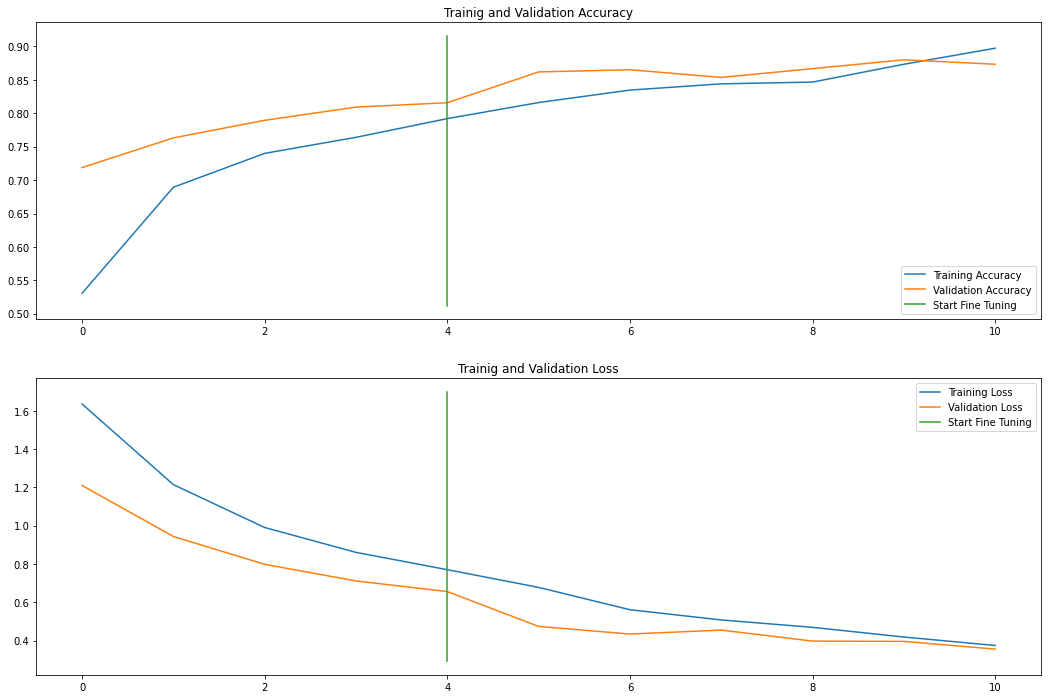

In [97]:
concatenate_histories(history_2, history_2_1)

In [98]:
model_2.save('saved_models/model_3')

In [99]:
model_3 = tf.keras.models.load_model('saved_models/model_3')
model_3.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 906,042
Non-train

### Create model_4
Fine-tuning an existing model on all the data


In [100]:
# Download 10 classes of food101 all training data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

--2022-08-21 14:33:38--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.12.128, 108.177.13.128, 172.217.193.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   297MB/s    in 1.7s    

2022-08-21 14:33:40 (297 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [101]:
# Unzip the data
unzip_data('10_food_classes_all_data.zip')

In [102]:
# Setup training and test dirs
train_dir_all = '10_food_classes_all_data/train'
test_dir_all = '10_food_classes_all_data/test'

In [103]:
# Walk through dirs
walk_through_dir('10_food_classes_all_data')

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 

In [104]:
# Setup datasets
IMG_SIZE = (224, 224)
train_data_all = image_dataset_from_directory(train_dir_all,
                                              label_mode='categorical',
                                              image_size=IMG_SIZE)

test_data_all = image_dataset_from_directory(test_dir_all,
                                             label_mode='categorical',
                                             image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


**Since we are interested in comapring model_3 and model_4, we will use model_2 with it's feature extraction weights as a base model**

In [105]:
# Copy model_2
model_4 = tf.keras.models.clone_model(model_2)
model_4.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 906,042
Non-train

In [106]:
# Compile model_4
model_4.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=['accuracy'])

In [107]:
model_4.load_weights(checkpoint_path)

In [108]:
model_2.evaluate(test_data_all)

79/79 [==============================] - 6s 67ms/step - loss: 0.4801 - accuracy: 0.8348


[0.48007118701934814, 0.8348000049591064]

In [109]:
model_3.evaluate(test_data_all)

79/79 [==============================] - 7s 69ms/step - loss: 0.4801 - accuracy: 0.8348


[0.4800712466239929, 0.8348000049591064]

In [110]:
model_4.evaluate(test_data_all)

79/79 [==============================] - 9s 68ms/step - loss: 0.8761 - accuracy: 0.7264


[0.8761492371559143, 0.7264000177383423]

**Model 4 with loaded weights of model 2 (after first fitting) is doing worse than model_3**

In [111]:
# Check trainable attribute of model_4 layers
for lay_num, layer in enumerate(model_4.layers):
  print(lay_num, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling2d_1 True
4 output_layer True


In [112]:
for lay_num, layer in enumerate(model_4.layers[2].layers):
  print(lay_num, layer.name, layer.trainable)

0 input_8 True
1 rescaling_4 False
2 normalization_4 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshap

In [113]:
# Fine-tune the model on full training dataset

history_4 = model_4.fit(
    train_data_all,
    epochs=10,
    validation_data=test_data_all,
    validation_steps=int(.25*len(test_data_all)),
    initial_epoch = history_2.epoch[-1],
    callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                           experiment_name='full_data')]
)

Saving TensorBoard log files to: transfer_learning/full_data/20220821-143440
Epoch 5/10
235/235 [==============================] - 26s 83ms/step - loss: 0.9312 - accuracy: 0.6936 - val_loss: 0.5399 - val_accuracy: 0.8191
Epoch 6/10
235/235 [==============================] - 19s 81ms/step - loss: 0.6725 - accuracy: 0.7796 - val_loss: 0.5465 - val_accuracy: 0.8289
Epoch 7/10
235/235 [==============================] - 19s 82ms/step - loss: 0.5594 - accuracy: 0.8156 - val_loss: 0.5115 - val_accuracy: 0.8487
Epoch 8/10
235/235 [==============================] - 19s 82ms/step - loss: 0.4864 - accuracy: 0.8391 - val_loss: 0.3875 - val_accuracy: 0.8766
Epoch 9/10
235/235 [==============================] - 20s 86ms/step - loss: 0.4180 - accuracy: 0.8575 - val_loss: 0.4303 - val_accuracy: 0.8734
Epoch 10/10
235/235 [==============================] - 19s 82ms/step - loss: 0.3854 - accuracy: 0.8719 - val_loss: 0.4893 - val_accuracy: 0.8503


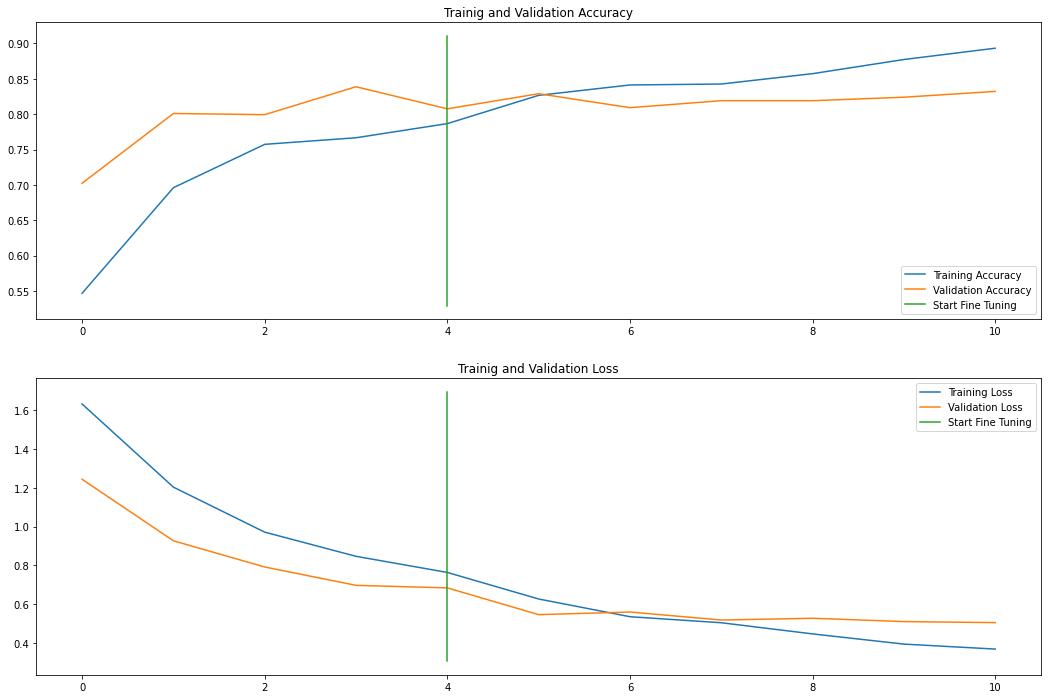

In [ ]:
concatenate_histories(history_2, history_2_1)

In [114]:
model_4.evaluate(test_data_all)

79/79 [==============================] - 6s 68ms/step - loss: 0.5018 - accuracy: 0.8504


[0.5017887353897095, 0.8503999710083008]

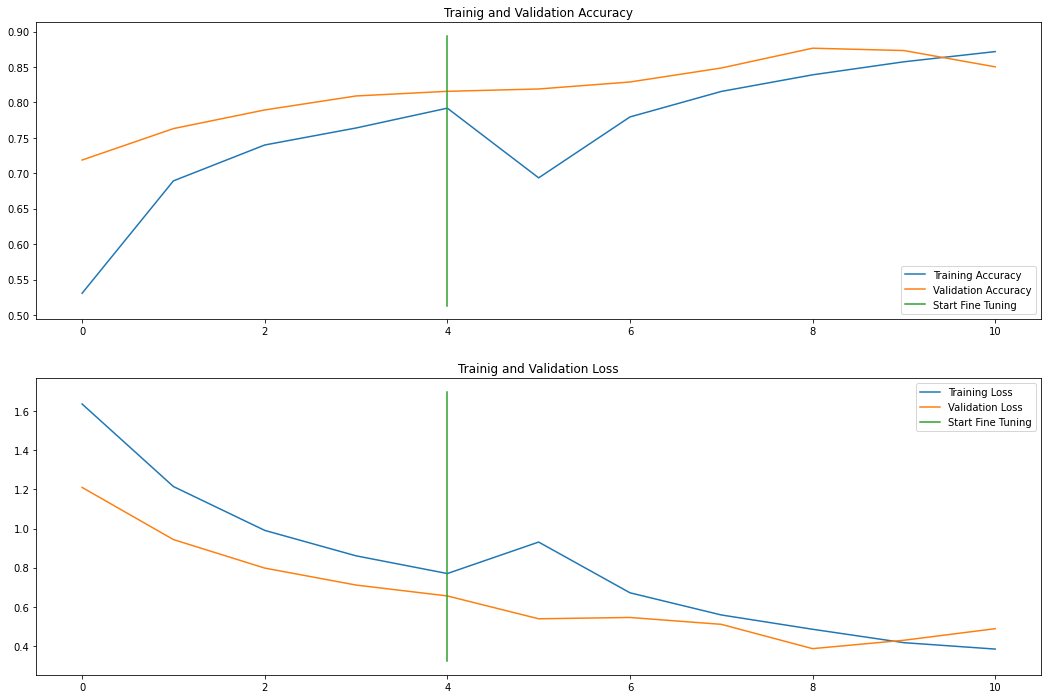

In [115]:
concatenate_histories(history_2, history_4)

### Compare 4 models in TensorBoard

In [116]:
# View tensorboard logs and upload Tensorboard dev records

!tensorboard dev upload --logdir ./transfer_learning \
  --name 'Transfer Learning Experiments with 10 Food101 Classes' \
  --one_shot # exits the uploader


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=klNXrb2gGgIEJBOgKi9EB3Jn3bQKbE&prompt=consent&access_type=o

TensorBoard for this experiment: https://tensorboard.dev/experiment/ggrAgfQPTNK1VOXd14NSnA/ 